## Topological Data Analysis - Part 2 - Persistent Homology

This is Part 2 in a series on topological data analysis.
See <a href="TDApart1.html">Part 1</a> | <a href="TDApart3.html">Part 3</a> | <a href="TDApart4.html">Part 4</a> | <a href="TDApart5.html">Part 5</a>

------------

The time has come for us to finally start coding. Generally my posts are very practical and involve coding right away, but topological data analysis can't be simplified very much, one really must understand the underlying mathematics to make any progress.

We're going to learn how to build a VR complex from simulated data that we sample from a circle (naturally) embedded in $\mathbb R^2$.

So we're going to randomly sample points from this shape and pretend it's our raw point cloud data. Many real data are generated by cyclical processes, so it's not an unrealistic exercise. Using our point cloud data, we will build a Vietoris-Rips simplicial complex as described (in math terms) above. Then we'll have to develop some more mathematics to determine the homology groups of the complex.

Recall the parametric form of generating the point set for a circle is as follows:
<br />
$x=a+r\cos(⁡\theta),$ <br />
$y=b+r\sin(\theta)$ <br />
where $(a,b)$ is the center point of the circle, $\theta$ is a parameter from $0 \text{ to } 2\pi$, and $r$ is the radius.

The following code will generate the discrete points of sampled circle and graph it.

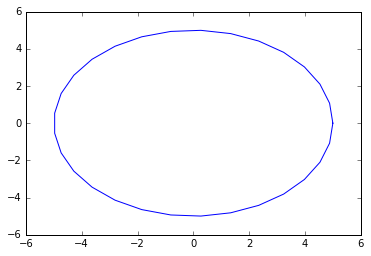

In [3]:
import numpy as np
import matplotlib.pyplot as plt

n = 30 #number of points to generate

#generate space of parameter
theta = np.linspace(0, 2.0*np.pi, n) 

a, b, r = 0.0, 0.0, 5.0

x = a + r*np.cos(theta)
y = b + r*np.sin(theta)

#code to plot the circle for visualization
plt.plot(x, y)
plt.show()

Okay, let's stochastically sample from this (somewhat) perfect circle, basically add some jitteriness.

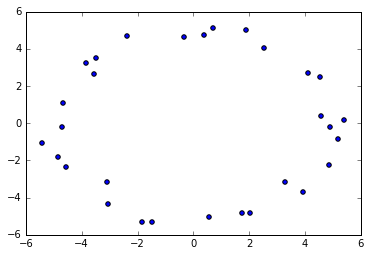

In [4]:
x2 = np.random.uniform(-0.75,0.75,n) + x #add some "jitteriness" to the points
y2 = np.random.uniform(-0.75,0.75,n) + y
fig, ax = plt.subplots()
ax.scatter(x2,y2)
plt.show()

As you can tell, the generated points look "circular" as in there is a clear loop with a hole, so we want our simplicial complex to capture that property.

Let's break down the construction of the VR complex into digestable steps: <br />

1. Define a distance function $d(a,b) = \sqrt{(a_1-b_1)^2+(a_2-b_2)^2}$ (Euclidian distance metric)
2. Establish the $\epsilon$ parameter for constructing a VR complex
3. Create a collection (python *list*, closest thing to a mathematical *set*) of the point cloud data, which will be the 0-simplices of the complex.
4. Scan through each pair of points, calculate the distance between the points. If the pairwise distance between points is $< \epsilon$, we add an edge between those points. This will generate a 1-complex (a graph).
5. Once we've calculated all pairwise distances and have a (undirected) graph, we can iterate through each vertex, identify its neighbors (points to which it has an egde) and attempt to build higher-dimensional simplices incrementally (e.g. from our 1-complex (graph), add all 2-simplices, then add all 3-simplices, etc)

There are many algorithms for creating a simplicial complex from data (and there are many other types of simplicial complexes besides the vietoris-rips complex). Unfortunately, to my knowledge, there are no polynomial-time algorithms for creating a full (not downsampled) simplicial complex from point data. So no matter what, once we start dealing with really big data sets, building the complex will become computationally expensive (even prohibitive). A lot more work needs to be done in this area.

We will be using the algorithm as described in "Fast Construction of the Vietoris-Rips Complex" by Afra Zomorodian. This algorithm operates in two major steps.
1. Construct the __neighborhood graph__ of point set data. The neighborhood graph is an undirected weighted graph $(G,w)$ where $G = (V,E), V$ is the node/vertex set and $E$ is the edge set, and $w : E \rightarrow \mathbb R$ ($w$ is a function mapping each edge in $E$ to a real number, it's weight). Recall our edges are created by connecting points that are within some defined distance of each other (given by a parameter $\epsilon$). Specifically, $$E_{\epsilon} = \{\{u,v\} \mid d(u,v) \leq \epsilon, u \neq v \in V\}$$ where $d(u,v)$ is the metric/distance function for two points $u,v \in V$. And the weight function simply assigns each edge a weight which is equal to the distance between the pair of points in the edge. That is, $w(\{u,v\}) = d(u,v), \forall\{u,v\} \in E_{\epsilon}(V)$

2. Peform a __Vietoris-Rips expansion__ on the neighborhood graph from step 1. Given a neighborhood graph $(G,w)$, the weight-filtered (will explain this soon) Vietoris-Rips complex $(R(G), w)$ (where $R$ is VR complex) is given by:
$$R(G) = V \cup E \cup \{ \sigma \mid \left ({\sigma}\above 0pt {2} \right ) \subseteq E \} , $$
For $\sigma \in R(G) \\$,
$$ w(\sigma) = 
\left\{
\begin{array}{ll} 
 0,  & \sigma = \{v\},v \in V,  \\
 w(\{u,v\}), & \sigma = \{u,v\} \in E  \\
 \displaystyle \operatorname*{max}_{\rm \tau \ \subset \ \sigma} w(\tau), & otherwise.
 \end{array} 
 \right\} 
$$

Okay what does that mean? Well, in this simple example, we want to get from our neighborhood graph (left) to our Vietoris-Rips complex (right):
<img src="images/TDAimages/VRconstruct1.svg" />

So the math above is saying that our Vietoris-Rips complex is the set that is the union of all the vertices and edges in our neighborhood graph (which takes us to a 1-complex), and the union of all simplices $\sigma$ (remember $\sigma$ is just a set of vertices) where each possible combination of 2 vertices in $\sigma$ is in $E$ (hence the $\left ({\sigma}\above 0pt {2} \right ) \subseteq E$ part). 

The next part defines the weight function for each simplex in our VR complex, from individual 0-simplices (vertices) to the highest dimensional simplex. If the simplex is a 0-simplex (just a vertex), then the weight of that simplex is 0. If the simplex is a 1-simplex (an edge), then the weight is the distance (defined by our distance function) between those two vertices in teh edge. If the simplex is a higher-dimensional simplex, like a 2-simplex (triangle), then the weight is the weight of the longest edge in that simplex.

Before we get to computing the VR complex for our "circle" data from earlier, let's just do a sanity check with the simple simplex shown above. We'll embed the vertices in $\mathbb R^2$ and then attempt to build the neighborhood graph first. 

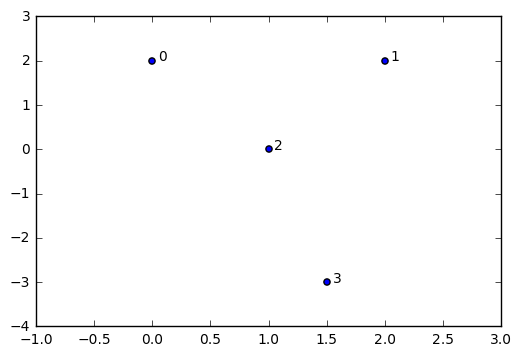

In [7]:
raw_data = np.array([[0,2],[2,2],[1,0],[1.5,-3.0]]) #embedded 3 vertices in R^2
plt.axis([-1,3,-4,3])
plt.scatter(raw_data[:,0],raw_data[:,1]) #plotting just for clarity
for i, txt in enumerate(raw_data):
    plt.annotate(i, (raw_data[i][0]+0.05, raw_data[i][1])) #add labels
plt.show()

We'll be representing each vertex in our simplicial complex by the index number in the original data array. For example, the point [0,2] shows up first in our data array, so we reference it in our simplicial complex as simply point [0].

In [8]:
#Build neighorbood graph
nodes = [x for x in range(raw_data.shape[0])] #initialize node set, reference indices from original data array
edges = [] #initialize empty edge array
weights = [] #initialize weight array, stores the weight (which in this case is the distance) for each edge
eps = 3.1 #epsilon distance parameter
for i in range(raw_data.shape[0]): #iterate through each data point
    for j in range(raw_data.shape[0]-i): #inner loop to calculate pairwise point distances
        a = raw_data[i]
        b = raw_data[j+i] #each simplex is a set (no order), hence [0,1] = [1,0]; so only store one
        if (i != j+i):
            dist = np.linalg.norm(a - b) #euclidian distance metric
            if dist <= eps:
                edges.append({i,j+i}) #add edge
                weights.append([len(edges)-1,dist]) #store index and weight
print("Nodes: " , nodes)
print("Edges: " , edges)
print("Weights: ", weights)

Nodes:  [0, 1, 2, 3]
Edges:  [{0, 1}, {0, 2}, {1, 2}, {2, 3}]
Weights:  [[0, 2.0], [1, 2.2360679774997898], [2, 2.2360679774997898], [3, 3.0413812651491097]]


Perfect. Now we have a node set, edge set, and a weights set that all constitute our neighborhood graph (G,$w$). Our next task is to use the neighborhood graph to start building up the higher-dimensional simplices. In this case we'll only have one additional 2-simplex (triangle). We'll need to setup a some basic functions.

In [2]:
def lower_nbrs(nodeSet, edgeSet, node):
    return {x for x in nodeSet if {x,node} in edgeSet and node > x}

def rips(nodes, edges, k):
    VRcomplex = [{n} for n in nodes]
    for e in edges: #add 1-simplices (edges)
        VRcomplex.append(e)
    for i in range(k):
        for simplex in [x for x in VRcomplex if len(x)==i+2]: #skip 0-simplices
            #for each u in simplex
            nbrs = set.intersection(*[lower_nbrs(nodes, edges, z) for z in simplex])
            for nbr in nbrs:
                VRcomplex.append(set.union(simplex,{nbr}))
    return VRcomplex

Great, let's try it out and see if it works. We're explicitly telling it to find all simplicies up to 3-dimensions.

In [10]:
theComplex = rips(nodes, edges, 3)
theComplex

[{0}, {1}, {2}, {3}, {0, 1}, {0, 2}, {1, 2}, {2, 3}, {0, 1, 2}]

Awesome, looks perfect.

Now we want to see what it looks like. I've produced some code that will graph the simplicial complex based on the output from our Vietoris-Rips algorithm from above. This is not crucial to understanding TDA (most of the time we don't try to visualize simplicial complexes as they are too high-dimensional) so I will not attempt to explain the code for graphing.

[ 0.  2.] [ 2.  2.]
[ 0.  2.] [ 1.  0.]
[ 2.  2.] [ 1.  0.]
[ 1.  0.] [ 1.5 -3. ]


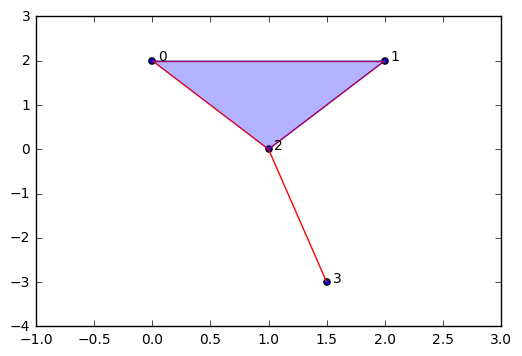

In [12]:
plt.clf()
plt.axis([-1,3,-4,3])
plt.scatter(raw_data[:,0],raw_data[:,1]) #plotting just for clarity
for i, txt in enumerate(raw_data):
    plt.annotate(i, (raw_data[i][0]+0.05, raw_data[i][1])) #add labels

#add lines for edges
for edge in [e for e in theComplex if len(e)==2]:
    pt1,pt2 = [raw_data[pt] for pt in [n for n in edge]]
    print(pt1,pt2)
    line = plt.Polygon([pt1,pt2], closed=None, fill=None, edgecolor='r')
    plt.gca().add_line(line)
    
#add triangles
for triangle in [t for t in theComplex if len(t)==3]:
    pt1,pt2,pt3 = [raw_data[pt] for pt in [n for n in triangle]]
    line = plt.Polygon([pt1,pt2,pt3], closed=False, color="blue",alpha=0.3, fill=True, edgecolor=None)
    plt.gca().add_line(line)
plt.show()

Now we have a nice little depiction of our very simple VR complex. Now that we know what to do. We need to learn about __simplicial homology__, which is the study of topological invariants between simplicial complexes. In particular, we're interested in being able to mathematically identify n-dimensional connected components, holes and loops. To aid in this effort, I've repackage the code we've used above as a separate file so we can just import it and use the functions conveniently on our data. You can download the latest code here: < https://github.com/outlace/OpenTDA/blob/master/SimplicialComplex.py >

Here I will zip our $x$ and $y$ coordinates from the (jittered) points we sampled from a circle so we can use it to build a more complicated simplicial complex.

In [7]:
newData = np.array(list(zip(x2,y2)))

In [8]:
import SimplicialComplex

In [9]:
graph = SimplicialComplex.buildGraph(raw_data=newData, epsilon=3.0)

In [10]:
ripsComplex = SimplicialComplex.rips(nodes=graph[0], edges=graph[1], k=3)

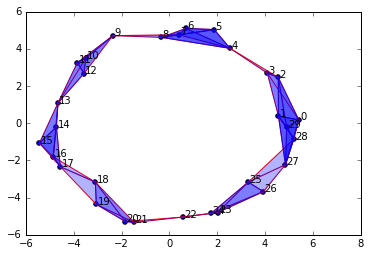

In [12]:
SimplicialComplex.drawComplex(origData=newData, ripsComplex=ripsComplex)

That's neat! Clearly we have reproduced the circular space from which the points were sampled. Notice that there are 1-simplices and higher-dimensional simplices (the darker blue sections) but it forms a single connected component with a single 1-dimensional hole.

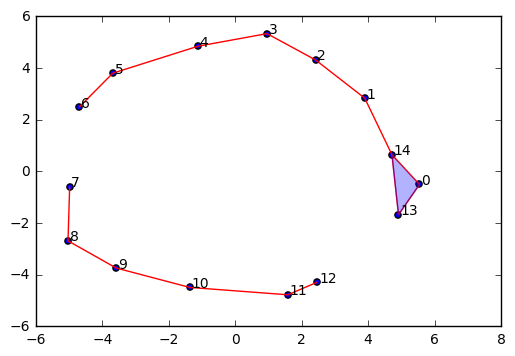

In [22]:
#This is what it looks like if we decrease the Epsilon parameter too much:

#### Homology Groups

Now that we know what simplicial complexes are and how to generate them on raw point data, we need to get to the next step of actually calculating the interesting topological features of these simplicial complexes.

Topologicla data analysis in the form of computational homology gives us a way of identifying the number of components and the number of n-dimensional "holes" (e.g. the hole in the middle of a circle) in some topological space (generally a simplicial complex) that we create based on a data set.

Before we proceed, I want to describe an extra property we can impose on the simplicial complexes we've been using thus far. We can give them an __orientation__ property. An oriented simplex $\sigma = {u_1, u_2, u_3, ... u_n}$ is defined by the order of its vertices. Thus the oriented simplex {a,b,c} is not the same as the oriented simplex {b,a,c}. We can depict this by making our edges into arrows when drawing low-dimensional simplicial complexes.

<img src="images/TDAimages/orientedSimplices.svg" />

Now, strictly speaking a mathematical set (designated with curcly braces ${}$) is by definition an unordered collection of objects, so in order to impose an orientation on our simplex, we would need add some additional mathematical structure e.g. via making the set of vertices an ordered set by adding a binary $\leq$ relation on the elements. This isn't particularly worth delving into, we'll just henceforth presume that the vertex sets are ordered without explicitly declaring the additional structure necessary to precisely define that order.

Looking back at the above two oriented simplices, we can see that the directionality of the arrows is exactly reverse for each simplex. If we call the left simplex $\sigma_1$ and the right $\sigma_2$ then we would say that $\sigma_1 = -\sigma_2$.

The reason for bringing in orientation will be made clear later.

##### n-Chains

Remember that a simplicial complex contains all faces of each highest-dimensional simplex in the complex. That is to say, if we have a 2-complex (a simplicial complex with the highest dimensional simplex being a 2-simplex (triangle)), then the complex also contains all of its lower dimensional faces (e.g. edges and vertices).

Let $\mathcal C = \text{{{0}, {1}, {2}, {3}, {0, 1}, {0, 2}, {1, 2}, {2, 3}, {0, 1, 2}}}$ be the simplicial complex constructed from a point cloud (e.g. data set), $X = \{0,1,2,3\}$.

$\mathcal C$ is a 2-complex since its highest-dimensional simplex is a 2-simplex (triangle). We can break this complex up into groups of subsets of this complex where each group is composed of the set of all $k$-simplices. In simplicial homology theory, these groups are called __chain groups__, and any particular group is the _k-th chain group_, $C_k(X)$. For example, the 1st-chain group of $\mathcal C$ is $\mathcal C_1(X) = \text{ {{0,1},{0,2},{1,2},{2,3}} }$

#### Basic Abstract Algebra

The "group" in "chain _group_" actually has a specific mathematical meaning that warrants covering. The concept of a __group__ is a notion from abstract algebra, the field of mathematics that generalizes some of the familiar topics from your high school algebra classes. Needless to say, it is fairly _abstract_, but I will do my best to start with concrete examples that are easy to conceptualize, then gently abstract away until we get to the most general notions. I'm going to be covering __groups, rings, fields, modules, and vector spaces__ and various other minor topics as they arise. Once we get this stuff down, we'll return to our discussion of _chain groups_.

Basically my only requirement of you, the reader, is that you already have an understanding of basic _set theory_. So if you've been lying to me this whole time and some how understood what's going on so far, then stop and learn some set theory because you're going to need it.

##### Groups

The mathematical structure known as a *group* can be thought of as generalizing a notion of symmetry. There's a rich body of mathematics that study groups known as (unsurprisingly) *group theory*. We won't go very far in our brief study of groups here, as we only need to know what we need to know. For our purposes, a group is a mathematical object that has some symmetrical properties to it. It might be easiest to think in terms of geometry, but as we will see, groups are so general that many different mathematical structures can benefit from a group theory perspective.
<img src="images/TDAimages/triangleGroupTheory.svg" />



Just by visual inspection, we can see a few of the possible operations we can perform on this triangle that will not alter its structure. I've drawn lines of symmetry showing that you can reflect across these 3 lines and still end up with the same triangle structure. More trivially, you can translate the triangle on the plane and still have the same structure. You can also rotate the triangle by 120 degrees and it still preserves the structure of the triangle. Group theory offers precise tools for managing these types of operations and their results. 

Here's the mathematical definition of a group. 
> A *group* is a set, $G$, together with a binary operation $\star$ (or whatever symbol you like) that maps any two elements $a,b \in G$ to another element $c \in G$, notated as $a\star b = c, \text{for all } a,b,c \in G$. The set and its operation are notated as the ordered pair $(G, \star)$. Additionally, to be a valid group, the set and its operation must satisfy the following axioms (rules):
>
>1. *Associativity* <br />
For all $\text{a, b and c in G}, (a \star b) \star c = a \star (b \star c)$.
>
>2. *Identity element* <br />
There exists an element $e \in G$ such that, for every element $a \in G$, the equation $e \star a = a \star e = a$ holds. Such an element is unique and is called the identity element.
>
>3. *Inverse element* <br />
For each $a \in G$, there exists an element $b \in G$, commonly denoted $a^{-1}$ (or $−a$, if the operation is denoted "$+$"), such that $a \star b = b \star a = e$, where $e$ is the identity element.
(Adapted from wikipedia)
>
> _NOTE:_ Notice that the operation $\star$ is not necessarily _commutative_, that is, $a \star b {?\above 0pt =} b \star a$. The order of operation may matter. If it does not matter, it is called a commutative or __abelian__ group. The set $\mathbb Z$ (the integers) is an _abelian_ group since e.g. $1+2 = 2+1$.

This "group" concept seems arbitrary and begs the question of what its use is, but hopefully that will become clear. Keep in mind all mathematical objects are simply sets with some (seemingly arbitrary) axioms (basically rules the sets must obey that define a structure on those sets). You can define whatever structure you want on sets (as long as they're logically consistent and coherent rules) and you'll have some mathematical object/structure. Some structures are more interesting than others. Some are sets have a lot of structure (i.e. a lot of rules) and others will have very few. Typically the structures with a lot of rules are merely specializations of more general/abstract structures. Groups are just mathematical structures (sets with rules that someone made up) that have interesting properties and turn out to be useful in a lot of areas. But since they are so general, it is a bit difficult to reason about them concretely.

Let's see if we can "group-ify" our triangle example from above. We can consider the triangle to be a set of labeled vertices, as if it were a 2-simplex. Since we've labeled the vertices of the triangle, we can easily describe it as the set $$t = \{a, b, c\}$$ But how do we define a binary operation on $t$? I'm not sure, let's just try things out. We'll build a table that shows us what happens when we "operate" on two elements in $t$. I'm seriously just going to make up a binary operation (a map from $(a,b) \mid a,b \in t$ ) and see if it turns out to be a valid group. Here it is.
<img src="images/TDAimages/GroupOpTable1.svg" width="150px" />
So to figure out what $a \star b$ is, you start from the top row, find $a$, then locate $b$ in the vertical left column, and where they meet up gives you the result. In my made up example, $a \star b = a$. Note that I've defined this operation to be NON-commutative, thus $a \star b \neq b \star a$. You have to start from the top row and then go to the left side row (in that order).

Now you should be able to quickly tell that this is in fact _not_ a valid group as it violates the axioms of groups. For example, check the element $b \in G$, you'll notice there is no identity element, $e$, for which $b + e = b$. 

So let's try again. This time I've actually _tried_ to make a valid group.
<img src="images/TDAimages/GroupOpTable2.svg" width="150px" />
You should check for yourself that this is in fact a valid group, and this time this group _is_ commutative, therefore we call it an abelian group. The identity element is $a$ since $a$ added to any other element $b$ or $c$ just gives $b$ or $c$ back unchanged. Notice that the table itself looks like it has some symmetry just by visual inspection. 

It turns out that finite groups, just like finite topological spaces, can be represented as directed graphs, which aids in visualization (aren't the patterns in math beautiful?). These graphs of groups have a special name: __Cayley graphs__. It's a little more complicated to construct a Cayley graph than it was to make digraphs for topological spaces. We have to add another property to Cayley graphs besides just having directed arrows (edges), we also assign an operation to each arrow. Thus if an arrow is drawn from $a \rightarrow b$ then that arrow represents the group operation on $a$ that produces $b$. And not all arrows are going to be the same operation, so to aid in visualization, we typically make each type of operation associated with an arrow a different color.

Before we construct a Cayley graph, we need to understand what a __generating set__ of a group is. Remember, a group is a set $G$ with a binary operation $\star$ (or whatever symbol you want to use), $(G, \star)$. A generating set is a subset $S \subseteq G$ such that $G = \{a \star b \mid a,b \in S\}$. In words, it means that the generating set $S$ is a subset of $G$ but if we apply our binary operation $\star$ on the elements in $S$, possibly repeatedly, it will produce the full set $G$. It's almost like $S$ compresses $G$. There may be many possible generators. So what is/are the generator(s) for our set $t = \{a,b,c\}$ with $\star$ defined in the table above? Well, look at the subsection of the operation table I've highlited red.
<img src="images/TDAimages/GroupOpTable2b.svg" width="150px" />

You'll notice I've highlighted the subset $\{b,c\}$ because these two elements can generate the full set $\{a,b,c\}$. But actually just $\{b\}$ and $\{c\}$ individually can generate the full set. For example, $b\star b=c$ and $b \star b \star b = a$ (we can also write $b^2 = c$ and $b^3 = a$). Similarly, $c \star c = b$ and $c \star c \star = a$. So by repeatedly applying the $\star$ operation on just $b$ or $c$ we can generate all 3 elements of the full set. Since $a$ is the identity element of the set, it is _not_ a generator as $a^n = a, n \in \mathbb N$ ($a$ to any positive power is still $a$).

Since there are two possible generators, $b$ and $c$, there will be two different "types" of arrows, representing two different operations. Namely, we'll have a "$b$" arrow and a "$c$" arrow (representing the $\star b \text{ and } \star c$ operations). To build the edge set $E$ for a Cayley graph of a group $(G, \star)$ and generator set $S \subseteq G$, is the edge set $$E = \{(a,c) \mid c = a\star b \land a,c \in G \land b \in S\}$$ where each edge is colored/labeled by $b \in S$.

The resulting Cayley graph is:
<img src="images/TDAimages/CayleyDiagram1.svg" />

In this Cayley graph we've drawn two types of arrows for the generators {b} and {c}, however, we really only need to choose one since only one element is necessary to generate the full group. So in general we choose the smallest generator set to draw the Cayley graph, in this case then we'd only have the red arrow.

So this group is the group of rotational symmetries of the equilateral triangle because we can rotate the triangle 120 degrees without changing it and our group codifies that by saying each turn of 120s is like the group operation of "adding" ($\star$) the generator element $b$. We can also add the identity element, which is like deciding not to rotate it at all. Here we can see how "adding" {b} to each element in the original set {a,b,c} looks like rotating counter-clockwise by 120 degrees:

<img src="images/TDAimages/triangleGroupOps2ex.svg" />

This is also called the _cyclic group of order 3_ which is isomorphic to $\mathbb Z_3$. Woah, isomorphic? $\mathbb Z_3$? What's all of that you ask?

Well isomorphic basically means there exists a one-to-one (bijective) mapping between two mathematical structures that maintains the structure. It's like they're the same structure but with different labelings. The rotational symmetry group of the triangle we just studied is isomorphic to the integers modulo 3 ( $\mathbb Z_3$ ). Modular arithmetic means that at some point the operation loops back to the beginning. Unlike the full integers $\mathbb Z$ where if you keep adding 1 you'll keep getting a bigger number, in modular arithmetic, eventually you add 1 and you'll loop back to the starting element (the identity element 0). Consider the hour hand on a clock, it is basically the integers modulo 12 ($\mathbb Z_{12}$) since if you keep adding one hour it eventually just loops back around.

Here's the addition table for the integers modulo 3:
<img src="images/TDAimages/GroupOpTable3.svg"  width="150px" />
Hence $1+1 = 2$ but $2+2 = 1$ and $1+2=0$ in $\mathbb Z_3$. The integers modulo $x$ forms a cyclic group (with a single generator) with $x$ elements and $0$ being the identity element.

Okay so that's the basics of groups, let's move on to rings and fields.

##### Rings and Fields

So now we move on to learning a bit about _rings_ and then _fields_. To preface, fields and rings are essentially specializations of groups, i.e. they are sets with the rules of groups plus additional rules. Every ring is a group, and every field is a ring.

> __Definition (Ring)__
A ring is a set $R$ equipped with two binary operations $\star$ and $\bullet$ (or whatever symbols you want to use) satisfying the following three sets of axioms, called the ring axioms: <br />
1. $R$ is an abelian (commutative) group over the $\star$ operation. Meaning that $(R, \star)$ satisfies the axioms for being a group.
2. $(R, \bullet)$ forms a mathematical structure called a __monoid__ when the $\bullet$ operation is associative < i.e. $a\bullet (b\bullet c) = (a \bullet b) \bullet c$ and $(R, \bullet)$ has an identity element (i.e. $\exists e \in R$ such that $e \bullet b = b \bullet e = e$ )
3. $\star$ is distributive with respect to $\bullet$, i.e. <br />
$a \bullet (b \star c) = (a \bullet b) \star (a \bullet c)$ for all $a, b, c \in R$ (left distributivity). <br />
$(b \star c) \bullet a = (b \bullet a) \star (c \bullet a)$ for all $a, b, c \in R$ (right distributivity). <br />
(Adapted from Wikipedia)

The most familiar ring is the integers, $\mathbb Z$, with the familiar operations $+$ (addition) and $\times$ (multiplication). Since a ring is also a group, we can speak of generators for the group of integers. Since the integers span from $\{-n...-3, -2, -1, 0, 1, 2, 3...n\}$ there are only two generators for the integers, namely $\{-1,1\}$ under the addition operation ($+$), since we can repeatedly do $1+1+1+...+n$ to get all the positive integers and $-1+-1+-1+...-n$ to get all the negative integers and $-1+1=0$ to get 0.

And here is the definition of a field.

> __Definition (Field)__
A _field_ is a set $F$ with two binary operations $\star$ and $\bullet$, denoted $F(\star, \bullet)$, that satisfy the following axioms.
> 
| name           | $\star$                                     | $\bullet$                                         |
|----------------|---------------------------------------------|---------------------------------------------------|
| associativity  | $(a \star b)\star c=a \star (b \star c)$    | $(a\bullet b)\bullet c=a \bullet (b \bullet c)$   |
| commutativity  | $a \star b=b \star a$                       | $a \bullet b=b \bullet a$                         |
| distributivity | $a(b \star c)=a\bullet b \star a \bullet c$ | $(a\star b)\bullet c=a\bullet c \star b\bullet c$ |
| identity       | $a \star e=a=0 \star a$                     | $a\bullet 1=a=1 \bullet a$                        |
| inverses       | $a \star (-a)=0=(-a) \star a$               | $a\bullet a^{(-1)}=1=a^{(-1)}\bullet a, \text{ if } a\neq 0$     |
...for all $a,b,c \in F$, where $0$ is the symbol for the identity element under the operation $\star$ and $1$ is the symbol for the identity element under the operation for $\bullet$.

Clearly, a field has a lot more requirements than just a group. And just to note, I know I've been using the symbols $\star$ and $\bullet$ for the binary operations of a group, ring and field, but these are more commonly denoted as $+$ and $\times$, called addition and multiplication, respectively. The only reason why I didn't initially use those symbols was because I wanted to emphasize the point that these do not just apply to numbers like you're familiar with, but are abstract operations that can function over any mathematical structures that meet the requirements. But now that you understand that, we can just use the more familiar symbols. So $\star = +$ (addition) and $\bullet = \times$ (multiplication) and $a \div b = a \times b^{-1}$ is division.

Remember the integers $\mathbb Z$ is the most familiar _ring_ with the operations additon and multiplication? Well the integers do not form a _field_ because there is not an inverse for each element in $\mathbb Z$ with respect to $\times$ operation. For example, if $\mathbb Z$ was a field then $5 \times 5^{-1} = 1$, however, $5^{-1}$ is not defined in the integers. If we consider the real numbers $\mathbb R$, then of course $5^{-1} = 1/5$. Thus a field, while defined just in terms of addition ($+$) and multiplication ($\times$), implicitly defines the inverses of those operations, namely substraction ($-$) and division ($/$). So for a set to be a field, the division operation (inverse of multiplication) must be defined for every element in the set _except_ for the identity element under the addition operation ($0$ in the case of $\mathbb Z$); as you know from elementary arithmetic that one cannot divide by 0 (since there is no inverse of $0$). And it all has to do with symmetry. The inverse of $1$ is $-1$ under addition, and $-2$ is the inverse of $2$ and so on.
<img src="images/TDAimages/integerInverses.png" />
Notice the symmetry of inverses? Each inverse is equidistant from the "center" of the set, that being $0$. But since $0$ is the center, there is no symmetrical opposite of it, thus $0$ has no inverse and cannot be defined with respect to division.

...

So stepping back a bit, group theory is all about studying symmetry. Any mathematical objects that have symmetrical features can be codified as groups and then studied algebraically to determine what operations can be done on those groups that preserve the symmetries. If we don't care about symmetry and we just want to study sets with a binary operation and associativity, then we're working with _monoids_. 

###### Why are we learning about groups, rings, and fields?

Ok, so we've learned the basics of groups, rings and fields, but why? Well I've already alluded that we'll need to understand groups to understand Chain groups which are needed to calculate the homology of simplicial complexes. But more generally, groups, rings and fields allow us to use the familiar tools of high school algebra on ANY mathematical objects that meet the relatively relaxed requirements of groups/rings/fields (not just numbers). So we can add, substract (groups), multiply (rings) and divide (fields) with mathematical objects like (gasp) simplicial complexes. Moreover, we can solve equations with unknown variables involving abstract mathematical objects that are not numbers.

##### Modules and Vector Spaces

Okay so there's a couple other mathematical structures from abstract algebra we need to study in order to be prepared for the rest of persistent homology, namely modules and vector spaces, which are very similar. Let's start with vector spaces since you should already be familiar with vectors. You should be familiar with vectors because generally we represent data as vectors, i.e., if we have an excel file with rows and columns, each row can be represented as an n-dimensional vector (n being the number of columns).

Intuitively then, vectors are n-dimensional lists of numbers, such as $[1.2,4.3,5.5,4.1]$. Importantly, I'm sure you're aware of the basic rules of adding vectors together and multiplying them by scalars. For example,
$$[1.2,4.3,5.5,4.1] + [1,3,2,1] = [1.2 + 1, 4.3 + 3, 5.5 + 2, 4.1 + 1] = [2.2,7.3,7.5,5.1]$$
...in words, when adding vectors, they have to be the same length, and you add each corresponding element. That is, the first element in each vector get added together, and so on. And for scaling...
$$ 2 \times [1.2,4.3,5.5,4.1] = [2.2, 8.6, 11.0, 8.2]$$
...each element in the vector gets multiplied by the scalar.

But wait! The way vectors are defined does not mention anything about the elements being NUMBERS or lists. A vector can be a set of ANY valid mathematical structure that meets the criteria of being a _field_. As long as the elements of a vector space can be scaled up or down by elements from a field (usually the real numbers or integers) and added together producing a new element still in the vector space.

Here's the formal definiton of a __vector space__, the mathematical structure whose elements are __vectors__.

> __Definition (Vector Space)__ <br />
A vector space $V$ over a field $F$ is a _set_ of objects called vectors, which can be added,
subtracted and multiplied by scalars (members of the underlying field). Thus $V$ is an
abelian group under addition, and for each $f \in F$ and $v \in V$ we have an element $fv \in V$ (the product of $f\times v$ is itself in $V$.)
Scalar multiplication is distributive and associative, and the multiplicative identity of the
field acts as an identity on vectors.

For example, the familiar vectors of numbers is from a vector space over the field $\mathbb R$.

Ok, so a __module__ is the same as a vector space, except that it is defined over a _ring_ rather than a field. And remember, every field _is_ a ring, so a module is a more relaxed (more general) mathematical structure than a vector space.

(Adapted from < http://www.math.uiuc.edu/~r-ash/Algebra/Chapter4.pdf >)

We should also talk about a __basis__ of a vector space (or module).

Say we have a finite set $S = \{a,b,c\}$ and we want to use this to build a module (or vector space). Well we can use this set as a basis to build module over some ring $R$. In this case, our module would be mathematically defined as:

$$M = \{(x* a, y* b, z* c) \mid x,y,z \in R\}$$ <br />
or equivalently: $$M = \{(x*g, y*g, z*g) \mid x,y,z \in R, g \in S\}$$
<br />
Where $*$ is the binary "multiplication" operation of our module. But since $R$ is a ring, it also must have a second binary operation that we might call "addition" and denote with $+$. Notice I use parenthesis because the order matters, i.e. $(a,b,c) \neq (b,a,c)$.

Now, every element in $M$ is of the form $\{xa,yb,zc\}$ (omitted the explicit $*$ operation for convenience) hence that forms a _basis_ of this module.

And we can add and scale each element of $M$ using elements from its underlying ring $R$. If we take the ring to be the integers, $\mathbb Z$ then we can add and scale in the following ways:
$$m_1, m_2 {\in M}\\
m_1 = (3a, b, 5c) \\
m_2 = (a, 2b, c) \\
m_1 + m_2 = (3a+a, b+2b, 5c+c) = (4a, 3b, 6c) \\
5*m_1 = 5 * (3a, b, 5c) = (5*3a, 5*b, 5*5c) = (15a, 5b, 25c)$$

This module is also a group (since every module and vector space is a group) if we only pay attention to the addition operation, but even though our generating set is a finite set like $\{a,b,c\}$, once we apply it over an infinite ring like the integers, we've constructed an infinite module or vector space.

In general, we can come up with multiple bases for a vector space, however, there is a mathematical theorem that tells us that all possible bases are of the same size. This leads us to the notion of __dimension__.  The dimension of a vector space (or module) is taken to be the size of its base. So for the example given above, the size of the base was 3 (the base has three elements) and thus that module has a dimension of 3.

As another example, take for example the vector space formed by $\mathbb R^2$ where $\mathbb R$ is the set of real numbers. This is defined as:
$$\mathbb R^2 = \{(x,y) \mid x,y \in \mathbb R\}$$
Basically we have an infinite set of all possible pairs of real numbers. One basis for this vector space is simply $(x,y) \mid x,y \in \mathbb R$, which feels the most natural as it is the simplest, but there's nothing forbidding us from making the basis $(2x+1.55,3y-0.718) \mid x,y \in \mathbb R$ since we end up with the same vector space. But no matter how we define our basis, it will always have 2 elements and thus its dimension is 2.

When we have a vector space, say of dimension 2, like $\mathbb R^2$, we can separate out its components like so:
$$ \mathbb R_x = \{(x, 0) \mid x \in \mathbb R\} \\
\mathbb R_y = \{(0, y) \mid y \in \mathbb R\} \\
\mathbb R^2 = \mathbb R_x \oplus \mathbb R_y $$
We can introduce new notation called a __direct sum__ $\oplus$, to signify this process of building out the dimensions of a vector space by a process like $(x,0)+(0,y)=(x+0,0+y)=(x,y) \mid x,y \in \mathbb R$. Thus we can more simply say $\mathbb R^2 = \mathbb R \oplus \mathbb R$.

We can also say that the base of $\mathbb R^2$ is the __span__ of the set $\{(1,0), (0,1)\}$, denoted $span\{(1,0), (0,1)\}$ or sometimes even more simply denoted using angle brackets $\langle\ (1,0), (0,1)\ \rangle$

$span\{(1,0), (0,1)\}$ is shorthand for saying "the set composed of all __linear combinations__ of the bases $(1,0)$ and $(0,1)$".

What is a linear combination? Well, in general, a linear combination of $x$ and $y$ is any expression of the form $ax + by$ where $a,b$ are constants in some field $F$. 

So a single possible linear combination of $(1,0)$ and $(0,1)$ would be: $5(1,0) + 2(0,1) = (5*1,5*0) + (2*0,2*1) = (5,0) + (0,2) = (5+0, 0+2) = (5, 2)$. But _all_ the linear combinations of $(1,0)$ and $(0,1)$ would be the expression: $\{a(1,0) + b(0,1) \mid a,b \in \mathbb R\}$ and this is the same as saying $span\{(1,0), (0,1)\}$ or $\langle\ (1,0), (0,1)\ \rangle$. And this set of all ordered pairs of real numbers is denoted by $\mathbb R^2$.

What's important about bases of a vector space is that they must be __linearly independent__, this means that one element _cannot_ be expressed as a linear combination of the other. For example, the base element $(1,0)$ cannot be expressed in terms of $(0,1)$. There is no expression $\not\exists a,b \in \mathbb R \land a,b\neq 0 \text{ such that }a(0,1) + b(1,0) = (1,0)$.

So in summary, a _basis_ of a vector space $V$ consists of a set of elements $B$ such that each element $b \in B$ is linearly independent and the span of $B$ produces the whole vector space $V$. Thus the dimension of the vector space dim$(V)$ is the number of elements in $B$.

(Reference: The Napkin Project by Evan Chen < http://www.mit.edu/~evanchen/napkin.html >)

##### Back to Chain Groups

Sigh. Ok, that was a lot of stuff we had to get through, but now we're back to the real problem we care about: figuring out the homology groups of a simplicial complex. As you may recall, we had left off discussing _chain groups_ of a simplicial complex. I don't want to have to repeat everything, so just scroll up and re-read that part if you forget. I'll wait...

Let $\mathcal S = \text{{{a}, {b}, {c}, {d}, {a, b}, {b, c}, {c, a}, {c, d}, {d, b}, {a, b, c}}}$ be an _oriented_ abstract simplicial complex (depicted below) constructed from some point cloud (e.g. data set). The __n-chain__, denoted $C_n(S)$ is the subset of $S$ of $n$-dimensional simplicies. For example, $C_1(S) = \text{ {{a, b}, {b, c}, {c, a}, {c, d}, {d, b}}}$ and $C_2(S) = \text{{a, b, c}}$.
<img src="images/TDAimages/simplicialcomplex5b.svg" />

Now, an _n-chain_ can become a __chain group__ if we give it a binary operation called addition that satisfies the group axioms. With this structure, we can add together $n$-simplicies in $C_n(S)$. More precisely, an $n$-chain group is the sum of $n$-chains with coefficients from a group, ring or field $F$. I'm going to use the same $C_n$ notation for a chain group as I did for an n-chain.
$$C_n(S) = \sum a_i \sigma_i$$
where $\sigma_i$ refers to the $i$-th simplex in the n-chain $C_n$, $a_i$ is the corresponding coefficient from a field, ring or group, and $S$ is the original simplicial complex.

Technically, any field/group/ring could be used to provide the coefficients for the chain group, however, for our purposes, the easiest group to work with is the cyclic group $\mathbb Z_2$, i.e. the integers modulo 2. $\mathbb Z_2$ only contains $\{0,1\}$ such that $1+1=0$ and is a _field_ because we can define an addition and multiplication operation that meet the axioms of a field. This is useful because we really just want to be able to either say a simplex exists in our n-chain (i.e. it has coefficient of $1$) or it does not (coefficient of $0$) and if we have a duplicate simplex, when we add them together they will cancel out. It turns out this is exactly the property we want. You might object that $\mathbb Z_2$ is not a group because it doesn't have an inverse, e.g. $-1$, but in fact it does, the inverse of $a$, for example, is $a$. Wait what? Yes, $a = -a$ under $\mathbb Z_2$ because $a + a = 0$. That's all that's required for an inverse to exist, you just need some element in your group such that $a+b=0; \forall a,b \in G$ ($G$ being a group).

If we use $\mathbb Z_2$ as our coefficient group, then we can essentially ignore simplex orientation. That makes it a bit more convenient. But for completeness sake, I wanted to incorporate orientations because I've most often seen people use the full set of integers $\mathbb Z$ as coefficients in academic papers and commercially. If we use a field with negative numbers like $\mathbb Z$ then our simplices need to be oriented, such that $[a,b] \neq [b,a]$. This is because, if we use $\mathbb Z$, then $[a,b] = -[b,a]$, hence $[a,b] + [b,a] = 0$.

Our ultimate goal, remember, is to mathematically find connected components and $n$-dimensional loops in a simplicial complex. Our simplicial complex $S$ from above, by visual inspection, has one connected component and one 2-dimensional loop or hole. Keep in mind that the simplex $\{a,b,c\} \in S$ is "filled in", there is no hole in the middle, it is a solid object.

We now move to defining __boundary maps__. Intuitively, a boundary map (or just a boundary for short) of an un-oriented $n$-simplex $X$ is the set of ${ {X} \choose {n-1}}$ subsets of $X$. That is, the boundary is the set of all $(n-1)$-subsets of $X$. For example, the boundary of $\{a,b,c\}$ is $\text{ {{a,b},{b,c},{c,a}} }$.

Let's give a more precise definition that applies to oriented simplices, and offer some notation.

> __Definition (Boundary)__ <br />
The boundary of an $n$-simplex $X$ with vertex set $[v_0, v_1, v_2, ... v_n]$, denoted $\partial(X)$, is: <br />
$$\partial(X) = \sum^{n}_{i=0}(-1)^{i}[v_0, v_1, v_2, \hat{v_i} ... v_n], \text{ where the $i$-th vertex is removed from the sequence}$$ <br />
The boundary of a single vertex is 0, $\partial([v_i]) = 0$.

For example, if $X$ is the 2-simplex $[a,b,c]$, then $\partial(X) = [b,c] + (-1)[a,c] + [a,b] = [b,c] + [c,a] + [a,b]$

Let's see how the idea of a boundary can find us a simple loop in the 2-complex example from above. We see that $[b,c] + [c,d] + [d,b]$ are the 1-simplices that form a cycle or loop. If we take the boundary of this set with the coefficient field $\mathbb Z$ then,
$$\partial([b,c] + [c,d] + [d,b]) = \partial([b,c]) + \partial([c,d]) + \partial([d,b])$$
$$\partial([b,c]) + \partial([c,d]) + \partial([d,b]) = [b] + (-1)[c] + [c] + (-1)[d] + [d] + (-1)[b]$$
$$\require{cancel} \cancel{[b]} + \cancel{(-1)[b]} + \cancel{(-1)[c]} + \cancel{[c]} + \cancel{(-1)[d]} + \cancel{[d]}  = 0$$

This leads us to a more general principle, a __$p$-cycle__ is an $n$-chain in $C_n$ whose boundary, $\partial(C_n) = 0$.

That is, in order to find the p-cycles in a chain group $C_n$ we need to solve the algebraic equation $\partial(C_n) = 0$ and the solutions will be the p-cycles. Don't worry, this will all make sense when we run through some examples shortly.

An important result to point out is that the boundary of a boundary is always 0, i.e. $\partial_n \partial_{n-1} = 0$

###### Chain Complexes

We just saw how the boundary operation is distributive, e.g. for two simplices $\sigma_1, \sigma_2 \in S$
$$ \partial(\sigma_1 + \sigma_2) = \partial(\sigma_1) + \partial(\sigma_2)$$

> __Definition (Chain Complex)__ <br />
Let $S$ be a simplicial $p$-complex. Let $C_n(S)$ be the $n$-chain of $S$, $n \leq p$. The chain complex, $\mathscr C(S)$ is:<br />
$$\mathscr C(S) = \sum^{p}_{n=0}\partial(C_n(S)) \text{ , or in other words...}$$ <br />
$$\mathscr C(S) = \partial(C_0(S)) + \partial(C_1(S)) \  + \ ... \ + \ \partial(C_p(S))$$

Now we can define how to describe find the $p$-cycles in a simplicial complex.

> __Definition (Kernel)__<br />
The kernel of $\partial(C_n)$, denoted $\text{Ker}(\partial(C_n))$ is the group of $n$-chains $Z_n \subseteq C_n$ such that $\partial(Z_n) = 0$

We're almost there, we need a couple more definitions and we can finally do some _simplicial homology_.

> __Definition (Image of Boundary)__ <br />
The image of a boundary $\partial_n$ (boundary of some $n$-chain), $\text{Im }(\partial_n)$, is the _set_ of boundaries. <br /><br />
For example, if a 1-chain is $C_1 = \{[v_0, v_1], [v_1, v_2], [v_2, v_0]\}$, <br />
then $\partial_1 = [v_0] + (-1)[v_1] + [v_1] + (-1)[v_2] + [v_2] + (-1)[v_0]$ <br />
$\text{Im }\partial_1 = \{[v_0-v_1],[v_1-v_2],[v_2-v_0]\}$

So the only difference between $\partial_n$ and Im $\partial_n$ is that the image of the boundary is in set form, whereas the boundary is in a polynomial-like form.

> __Definition ($n^{th}$ Homology Group)__ <br />
The $n^{th}$ Homology Group $H_n$ is defined as $H_n$ = Ker $\partial_n \ / \ \text{Im } \partial_{n+1}$.

> __Definition (Betti Numbers)__ <br/>
The $n^{th}$ Betti Number $b_n$ is defined as the dimension of $H_n$. <br />
$b_n = dim(H_n)$

#### More group theory

We've reached an impasse again requiring some exposition. I casually used the notion $/$ in defining a homology group to be Ker $\partial_n \ / \ \text{Im } \partial_{n+1}$. The mathematical use of this notation is to say that for some _group_ $G$ and $H$, a subgroup of $G$, then $G / H$ is the quotient group. Ok, so what is a quotient group? Alright, we need to learn more group theory. And unfortunately it's kind of hard, but I'll do my best to make it intuitive.

> __Definition (Quotient Group)__ <br />
For a group $G$ and a normal subgroup $N$ of $G$, denoted $N \leq G$, the quotient group of $N$ in $G$, written $G/N$ and read "$G$ modulo $N$", is the set of _cosets_ of $N$ in $G$. <br />
(Source: Weisstein, Eric W. "Quotient Group." From MathWorld--A Wolfram Web Resource. http://mathworld.wolfram.com/QuotientGroup.html)

For now you can ignore what a _normal_ subgroup means because all the groups we will deal with in TDA are abelian groups, and all subgroups of abelian groups are normal. But this definition just defines something in terms of something else called _cosets_. Annoying. Ok what is a coset?

> __Definition (Cosets)__ <br />
For a group $(G, \star)$, consider a subgroup $(H, \star)$ with elements $h_i$ and an element $x$ in $G$, then $x\star{h_i}$ for $i=1, 2, ...$ constitute the _left coset_ of the subgroup $H$ with respect to $x$. <br />
(Adapted from: Weisstein, Eric W. "Left Coset." From MathWorld--A Wolfram Web Resource. http://mathworld.wolfram.com/LeftCoset.html)

So we can ask what the left (or right) coset is of a subgroup $H \leq G$ with respect to some element $x \in G$ and that gives us a single coset, but if we get the set of _all_ left cosets (i.e. the cosets with respect to every element $x \in G$) then we have our quotient group $G\ /\ H$.

For our purposes, we only need to concern ourselves with _left_ cosets, because TDA only involves abelian groups, and for abelian groups, left cosets and right cosets are the same. (We _will_ see an example of a non-abelian group).

We'll reconsider the equilateral triangle and its symmetries to get a better sense of subgroups, quotient groups and cosets.
<img src="images/TDAimages/triangleGroupTheory.svg" />
Remember, by simple visualization we identified the types of operations we could perform on the equilateral triangle that preserve its structure: we can rotate it by 0, 120, or 240 degrees and we can reflect it across 3 lines of symmetry. Any other operations, like rotating by 1 degree, would produce a different structure when embedded in, for example, two-dimensional Euclidian space.

We can build a set of these 6 group operations:
$$S = \text{{$rot_0$, $rot_{120}$, $rot_{240}$, $ref_a$, $ref_b$, $ref_c$}}$$ <br />
...where $rot_0$ and so on means to rotate the triangle about its center 0 degrees (an identity operation), and $ref_a$ means to reflect across the line labeled $a$ in the picture above.

For example, we can take the triangle and apply two operations from $S$, such as $rot_{120}, ref_a$

<img src="images/TDAimages/triangleGroupOps1.svg" />
(note I'm being a bit confusing by labeling the vertices of the triangle $a,b,c$ but also labeling the lines of reflection $a,b,c$, but it should be obvious by context what I'm referring to.)

So does $S$ form a valid group? Well it does it we define a binary operation for each pair of elements it contains. And the operation $a \star b$ for any two elements in $S$ will simply mean "do $a$, then do $b$". The elements of $S$ are actions that we take on the triangle. We can build a multiplication (or Cayley) table that shows the result of applying the operation for every pair of elements.

Here's the Cayley table:

|                      | $\mathbf{rot_0}$ | $\mathbf{rot_{120}}$ | $\mathbf{rot_{240}}$ | $\mathbf{ref_a}$ | $\mathbf{ref_b}$ | $\mathbf{ref_c}$ |
|----------------------|------------------|----------------------|----------------------|------------------|------------------|------------------|
| $\mathbf{rot_0}$     | $rot_0$          | $rot_{120}$          | $rot_{240}$          | $ref_a$          | $ref_b$          | $ref_c$          |
| $\mathbf{rot_{120}}$ | $rot_{120}$      | $rot_{240}$          | $rot_0$              | $ref_c$          | $ref_a$          | $ref_b$          |
| $\mathbf{rot_{240}}$ | $rot_{240}$      | $rot_0$              | $rot_{120}$          | $ref_b$          | $ref_c$          | $ref_a$          |
| $\mathbf{ref_a}$     | $ref_a$          | $ref_b$              | $ref_c$              | $rot_0$          | $rot_{120}$      | $rot_{240}$      |
| $\mathbf{ref_b}$     | $ref_b$          | $ref_c$              | $ref_a$              | $rot_{240}$      | $rot_0$          | $rot_{120}$      |
| $\mathbf{ref_c}$     | $ref_c$          | $ref_a$              | $ref_b$              | $rot_{120}$      | $rot_{240}$      | $rot_0$          |


Notice that this defines a non-commutative (non-abelian) group, since in general $a \star b \neq b \star a$.

Now we can use the Cayley table to build a Cayley diagram and visualize the group $S$. Let's recall how to build a Cayley diagram. We will first start with our vertices (aka nodes), one for each of the 6 actions in our group $S$. Then we need to figure out the minimum generator for this group, that is, the minimal subset of $S$ that with various combinations and repeated applications of the group operation $\star$ will generate the full 6 element set $S$. It turns out that you just need $\{rot_{120}, ref_a\}$ to generate the full set, hence that subset of 2 elements is the minimal generating set. 

Now, each element in the generating set is assigned a different colored arrow, and thus starting from a node $a$ and following a particular arrow to another element $b$, means that $a \star g = b$ where $g$ is an element from the generating set. Thus for $S$, we will have a graph with two different types of arrows, and I will color the $rot_{120}$ arrow as blue and the $ref_a$ arrow as red. Then we use our Cayley table from above to connect the nodes with the two types of arrows. 

Here's the resulting Cayley diagram:

<img src="images/TDAimages/CayleyDiagramD6.svg" />

For the curious, it turns out this group is the smallest non-abelian finite group, it's called the "Dihedral group of order 6", and can be used to represent a number of other things besides the symmetry actions on an equilateral triangle.

We will refer to both this Cayley table and the Cayley diagram to get an intuition for the definitions we gave earlier for subgroups, cosets and quotient groups.

Let's start by revisiting the notion of a _subgroup_. A subgroup $(H,\star)$ of a group $(G,\star)$ (often denoted $H < G$) is merely a subset of $G$ with the same binary operation $\star$ that satisfies the group axioms. For example, every group has a trivial subgroup that just includes the identity element (any valid subgroup will need to include the identity element to meet the group axioms).

Consider the subgroup $W \leq S = \{rot_0, rot_{120}, rot_{240}\}$. Is this a valid subgroup? Well yes because it is a subset of $S$, contains the identity element, is associative, and each element has an inverse. For this example, the subgroup $W < S$ forms the outer circuit in the Cayley diagram (nodes highlighted green):

<img src="images/TDAimages/CayleyDiagramD6_2.svg" />

Okay, so a subgroup is fairly straightforward. What about a _coset_? Well referring back to the definition given previously, a coset is in reference to a particular subgroup. So let's consider our subgroup $W\leq S$ and ask what the _left cosets_ of this subgroup are. Now, I said earlier that we only need to worry about _left_ cosets because in TDA the groups are all abelian, well that's true, but the group of symmetries of the equilateral triangle is not _not_ an abelian group thus the left and right cosets will, in general, not be the same. We're just using the triangle to learn about group theory, once we get back to the chain groups of persistent homology, we'll be back to abelian groups.

Recall that the left cosets of some subgroup $H\leq G$ are denoted $xH = \{x\star{h} \mid \forall h \in H; \forall x \in G$\}<br />
And for completeness, the right cosets are $Hx = \{{h}\star{x} \mid \forall h \in H; \forall x \in G$\}<br />

Back to our triangle symmetries, group $S$ and its subgroup $W$. Recall, $W \leq S = \{rot_0, rot_{120}, rot_{240}\}$. To figure out the left cosets then, we'll start by choosing an $x\in S$ where $x$ is not in our subgroup $W$. Then we will multiply $x$ by each element in $W$. Let's start with $x = ref_a$.

So $ref_a \star \{rot_0, rot_{120}, rot_{240}\} = \{ref_a \star rot_0, ref_a \star rot_{120}, ref_a \star rot_{240}\} = \{ref_a, ref_b, ref_c\}$. So the left coset with respect to $ref_a$ is the set $\{ref_a, ref_b, ref_c\}$. Now, we're supposed to do the same with another $x \in S, x \not\in W$ but if we do, we just get the same set: $\{ref_a, ref_b, ref_c\}$. So we just have one left coset.

It turns our for this subgroup, the right and left coset are the same, the right being: $\{rot_0\star ref_a, rot_{120}\star ref_a, rot_{240}\star ref_a \} = \{ref_a, ref_b, ref_c\}$.

(Reference: < http://www.math.clemson.edu/~macaule/classes/m16_math4120/slides/math4120_lecture-3-02_handout.pdf >)

Interestingly, since all Cayley diagrams have symmetry themselves, in general the _left_ cosets of a subgroup will appear like copies of the subgroup in the Cayley diagram. If you consider our subgroup $W \leq S = \{rot_0, rot_{120}, rot_{240}\}$, it forms this outer "ring" in the Cayley diagram, and the left coset is the set of vertices that forms the inner "ring" of the diagram. So it's like they're copies of each other. Here's another example with the subgroup being $\{rot_0, ref_a\}$:

<img src="images/TDAimages/CayleyDiagramD6_3.svg" />

So we begin to see how the left cosets of a subgroup of a group appear to evenly partition the group into pieces of the same form as the subgroup. With the subgroup being $W \leq S = \{rot_0, rot_{120}, rot_{240}\}$ we could partition the group $S$ into two pieces that both have the form of $W$, whereas if the subgroup is $\{rot_0, ref_a\}$ then we can partition the group $S$ into 3 pieces that have the same form as the subgroup.

This leads us directly to the idea of a __quotient group__. Recall the definition given earlier: 
>For a group $G$ and a normal subgroup $N$ of $G$, denoted $N \leq G$, the quotient group of $N$ in $G$, written $G/N$ and read "$G$ modulo $N$", is the set of _cosets_ of $N$ in $G$. <br />

A _normal subgroup_ is just a subgroup in which the left and right cosets are the same. Hence, our subgroup $W \leq S = \{rot_0, rot_{120}, rot_{240}\}$ is a normal subgroup as we discovered. We can use it to construct the quotient group, $S / W$.

Now that we know what cosets are, it's easy to find what $S / W$, it's just the set of (left or right, they're the same) cosets with respect to $W$, and we already figured that out, the cosets are just: 
$$ S\ /\ W = \{\{rot_0, rot_{120}, rot_{240}\}, \{ref_a, ref_b, ref_c\}\}$$ <br />
(we include the subgroup itself in the set since the cosets of a subgroup technically includes itself).

Okay so this is really interesting for two reasons, we've taken $S\ /\ W$ and it resulted in a set with _2_ elements (the elements themselves being sets), so in a sense, we took an original set (the whole group) with 6 elements and "divided" it by a set with 3 elemenets, and got a set with 2 elements. Seem familiar? Yeah, seems like the simple arithmetic $6\ /\ 3=2$. And that's because division over the real numbers is defined in exactly this way, using cosets and quotient groups. The second reason it's interesting, is that the two elements in our quotient group are the basic two _kinds_ of operations on our triangle, namely _rotation_ operations and _reflection_ operations. 

I also just want to put out that our resulting quotient group $ S\ /\ W $ is in fact itself a group, that is, it meets all the group axioms, and in this example, is isomorphic to the integers modulo 2 ($\mathbb Z_2$).

So intuitively, whenever you want some quotient group $A\ /\ B$ where $B \leq A$ (B is a subgroup of A), just ask yourself, "how can I partition $A$ into $B$-like pieces?" And the partitions do NOT need to be non-overlapping. In this case our partition was non-overlapping, i.e. each coset in the quotient group had no elements in common, but that is not always the case. Consider the cyclic group $\mathbb Z_4$ with the single generator $1$:
<img src="images/TDAimages/cyclicGroupZ4.svg" width="200px" />
We could partition this group into pieces of 2, but there are in fact two ways to do this. We could make a subgroup $N \leq \mathbb Z_4 = \{0,2\}$, which would partition the space into only two pieces (there are 2 left cosets, hence our quotient group is of size 2). We've depicted this below, where each "piece" is the pair of elements "across from each other" in the Cayley diagram.

<img src="images/TDAimages/cyclicGroupZ4_partDim2.svg" width="200px" />
$$ N = \{0,2\} \\
N \leq \mathbb Z_4 \\
\mathbb Z_4\ /\ N = \{\{0,2\},\{1,3\}\}$$
But we could also choose a subgroup $N \leq \mathbb Z_4 = \{0,1\}$ where each pair of elements is right next to each other. In this case, we can partition the group into 4 pieces (i.e. the set of left cosets or the quotient group has 4 elements).
<img src="images/TDAimages/cyclicGroupZ4_partDim4.svg" width="200px" />
$$ N = \{0,1\} \\
N \leq \mathbb Z_4 \\
\mathbb Z_4\ /\ N = \{\{0,1\},\{1,2\},\{2,3\},\{3,0\}\}$$
<br />

The last thing I want to mention is the idea of an __algebraically closed group__ versus non-closed groups. Basically, a group that is closed is one in which the solution to any equation with the group is also contained in the group. For example, if we consider the cyclic group $\mathbb Z_2$ which consists of $\{0,1,2\}$, then the solution to the equation $x^2 = 1$ is $1$ which is in our group $\{0,1,2\}$. However, if we can come up with an equation whose solution is not in $\mathbb Z_2$ but say only found in the reals $\mathbb R$, then our group is not closed. In fact, it's quite easy, just ask the solution to $x/3=1$ and we realized the solution, $3$, is not in $\mathbb Z_2$.

(Ref: < https://en.wikipedia.org/wiki/Algebraically_closed_group >)

###### Next time...

So we've actually covered most of the basic mathematics knowledge that we'll need to actually start using simplicial complexes to calculate topological features, so that is what we'll begin to do next time.

#### References (Websites):

1. http://dyinglovegrape.com/math/topology_data_1.php
2. http://www.math.uiuc.edu/~r-ash/Algebra/Chapter4.pdf
3. https://en.wikipedia.org/wiki/Group_(mathematics)
4. https://jeremykun.com/2013/04/03/homology-theory-a-primer/
5. http://suess.sdf-eu.org/website/lang/de/algtop/notes4.pdf
6. http://www.mit.edu/~evanchen/napkin.html

#### References (Academic Publications):
7. Basher, M. (2012). On the Folding of Finite Topological Space. International Mathematical Forum, 7(15), 745–752. Retrieved from http://www.m-hikari.com/imf/imf-2012/13-16-2012/basherIMF13-16-2012.pdf

8. Day, M. (2012). Notes on Cayley Graphs for Math 5123 Cayley graphs, 1–6.

9. Doktorova, M. (2012). CONSTRUCTING SIMPLICIAL COMPLEXES OVER by, (June).

10. Edelsbrunner, H. (2006). IV.1 Homology. Computational Topology, 81–87. Retrieved from http://www.cs.duke.edu/courses/fall06/cps296.1/

11. Erickson, J. (1908). Homology. Computational Topology, 1–11.

12. Evan Chen. (2016). An Infinitely Large Napkin.

13. Grigor’yan, A., Muranov, Y. V., & Yau, S. T. (2014). Graphs associated with simplicial complexes. Homology, Homotopy and Applications, 16(1), 295–311. http://doi.org/10.4310/HHA.2014.v16.n1.a16

14. Kaczynski, T., Mischaikow, K., & Mrozek, M. (2003). Computing homology. Homology, Homotopy and Applications, 5(2), 233–256. http://doi.org/10.4310/HHA.2003.v5.n2.a8

15. Kerber, M. (2016). Persistent Homology – State of the art and challenges 1 Motivation for multi-scale topology. Internat. Math. Nachrichten Nr, 231(231), 15–33.

16. Khoury, M. (n.d.). Lecture 6 : Introduction to Simplicial Homology Topics in Computational Topology : An Algorithmic View, 1–6.

17. Kraft, R. (2016). Illustrations of Data Analysis Using the Mapper Algorithm and Persistent Homology.

18. Lakshmivarahan, S., & Sivakumar, L. (2016). Cayley Graphs, (1), 1–9.

19. Liu, X., Xie, Z., & Yi, D. (2012). A fast algorithm for constructing topological structure in large data. Homology, Homotopy and Applications, 14(1), 221–238. http://doi.org/10.4310/HHA.2012.v14.n1.a11

20. Naik, V. (2006). Group theory : a first journey, 1–21.

21. Otter, N., Porter, M. A., Tillmann, U., Grindrod, P., & Harrington, H. A. (2015). A roadmap for the computation of persistent homology. Preprint ArXiv, (June), 17. Retrieved from http://arxiv.org/abs/1506.08903

22. Semester, A. (2017). § 4 . Simplicial Complexes and Simplicial Homology, 1–13.

23. Singh, G. (2007). Algorithms for Topological Analysis of Data, (November).

24. Zomorodian, A. (2009). Computational Topology Notes. Advances in Discrete and Computational Geometry, 2, 109–143. Retrieved from http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.50.7483

25. Zomorodian, A. (2010). Fast construction of the Vietoris-Rips complex. Computers and Graphics (Pergamon), 34(3), 263–271. http://doi.org/10.1016/j.cag.2010.03.007

26. Symmetry and Group Theory 1. (2016), 1–18. http://doi.org/10.1016/B978-0-444-53786-7.00026-5